In [1]:
# loading packages
import numpy as np
import matplotlib.pylab as plt
import torch
import pandas as pd
import gpytorch
from gpytorch.mlls import VariationalELBO

from scipy.stats import norm
torch.manual_seed(8927)
np.random.seed(8927)
torch.set_default_dtype(torch.float64)

import warnings
warnings.filterwarnings("ignore")

from gpytorch.models import ApproximateGP
from gpytorch.mlls import VariationalELBO
from gpytorch.priors import NormalPrior, MultivariateNormalPrior
from gpytorch.likelihoods import BernoulliLikelihood
from gpytorch.variational import VariationalStrategy
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.means import ConstantMean
from gpytorch.kernels import LinearKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
from torch.nn import ModuleList

from utilities.util import MyDirichletClassificationLikelihood

In [2]:
# load data
data = pd.read_csv("./data/item_long_unimp.csv")

# SID: the subject ID
# all_beeps: the assessment wave
# Trait: one of the Big Five
# Facet: one of the facets hypothesized to be under one of the Big Five traits (3 of each big 5)
# Item: the item name (4 per facet)
# Value: the rating 

data = data[(data.all_beeps<=2000)]
SIDs = data.SID.unique()
SIDs.sort()
Items = data.Item.unique()
Items.sort()
Beeps = data.all_beeps.unique()
Beeps.sort()
TRAITS = data.Trait.unique()
C = max(data.value.unique())

n = len(SIDs)
m = len(Items)
horizon = len(Beeps)
Q = len(TRAITS)

# x: [i,j,h]
train_x = torch.zeros((data.shape[0],3))
train_y = torch.zeros((data.shape[0],))

iter = 0
for _, row in data.iterrows():
    i = np.where(row["SID"]==SIDs)[0][0]
    j = np.where(row["Item"]==Items)[0][0]
    h = np.where(row["all_beeps"]==Beeps)[0][0]
    train_x[iter, 0] = i
    train_x[iter, 1] = j
    train_x[iter, 2] = h
    train_y[iter] = row["value"] - 1
    iter += 1

train_ratio = 0.8
train_mask = np.zeros((data.shape[0],))
train_mask[np.random.choice(data.shape[0], int(data.shape[0]*train_ratio),replace=False)] = 1
test_x = train_x[train_mask==0]
test_y = train_y[train_mask==0]
train_x = train_x[train_mask==1]
train_y = train_y[train_mask==1]

Dirichlet-based Gaussian Processes for Large-Scale Calibrated Classification

In [13]:
from gpytorch.models import ApproximateGP
from gpytorch.kernels import RBFKernel, IndexKernel
from utilities.util import MyDirichletClassificationLikelihood, OrdinalLikelihood
from gpytorch.means import Mean

class ConstantVectorMean(Mean):
    def __init__(self, size, prior=None, batch_shape=torch.Size(), **kwargs):
        super().__init__()
        self.batch_shape = batch_shape
        self.register_parameter(name="constantvector",\
                 parameter=torch.nn.Parameter(torch.zeros(*batch_shape, *size)))
        if prior is not None:
            self.register_prior("constantvector_prior", prior, "constantvector")

    def forward(self, input):
        results = torch.zeros((input.shape[0],))
        for i in range(input.shape[0]):
            results[i] = self.constantvector[input[i,0].int(),input[i,1].int()]
        return results

class OrdinalLMC(ApproximateGP):
    def __init__(self, inducing_points, n, m, C):
        self.C = C # cardinality of responses

        # Sparse Variational Formulation
        q_u = CholeskyVariationalDistribution(inducing_points.size(0))
        q_f = VariationalStrategy(self, inducing_points, q_u, \
                                  learn_inducing_locations=True)
        super().__init__(q_f)

        self.mean_module = ConstantVectorMean(size=torch.Size((n,m)))
        self.covar_module = RBFKernel(active_dims=[0]) * \
                RBFKernel(active_dims=[2])
        self.task_covar_module = IndexKernel(num_tasks=m, rank=10)

    def forward(self, x):
        mean_x = self.mean_module(x[:,:2])
        covar_x = self.covar_module(x) * self.task_covar_module(x[:,1])
        dist = MultivariateNormal(mean_x, covar_x)
        return dist

In [14]:
from gpytorch.constraints import Positive
import pandas as pd
import torch
from gpytorch.means import Mean
from gpytorch.module import Module
from gpytorch.mlls import KLGaussianAddedLossTerm
from torch.distributions import MultivariateNormal
from typing import Optional, Tuple

#!/usr/bin/env python3

import warnings

import torch

from gpytorch.distributions import base_distributions
from gpytorch.functions import log_normal_cdf
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood


class OrdinalLikelihood(_OneDimensionalLikelihood):
    r"""
    Implements the Ordinal likelihood used for GP classification, using
    logit regression (i.e., the latent function is warped to be in [0,1]
    using the standard Normal CDF :math:`\Phi(x)`).
    .. math::
        \begin{equation*}
            p(Y=c|f)=\Phi(b_c-f)-\Phi(b_{c-1}-f)
        \end{equation*}
    """
    has_analytic_marginal: bool = True

    def __init__(self, thresholds, **kwargs):
        super().__init__(**kwargs)
        self.C = thresholds.shape[0] - 1
        thresholds, _ = torch.sort(thresholds)
        if self.C>2:
            self.register_parameter("b1", parameter=torch.nn.Parameter(\
                torch.Tensor(thresholds[1])))
        if self.C>3:
            self.register_parameter("deltas", parameter=torch.nn.Parameter(\
                self._threshold_to_delta(thresholds)))
            self.register_constraint("deltas", Positive())
        
    def _threshold_to_delta(self, thresholds):
        C = self.C
        deltas = torch.zeros((C-2,))
        deltas[0] = thresholds[1]
        for c in range(2,C):
            deltas[c-2] = thresholds[c] - thresholds[c-1]
        return deltas
    
    def _delta_to_threshold(self, b1, deltas):
        C = self.C
        thresholds = torch.zeros((C+1,))
        thresholds[0] = torch.tensor([float('-inf')])
        thresholds[C] = torch.tensor([float('inf')])
        thresholds[1] = b1
        for c in range(2,C):
            thresholds[c] = thresholds[c-1] + deltas[c-2]
        return thresholds
    
    def _get_thresholds(self):
        thresholds = torch.zeros(self.C+1,)
        thresholds[0] = float("-inf")
        thresholds[self.C] = float("inf")
        if self.C>2:
            thresholds[1] = self.b1.data
        if self.C>3:
            thresholds[2:self.C] = self.delta.data
        return thresholds

    def forward(self, function_samples, **kwargs):
        thresholds = self._get_thresholds()
        link2 = thresholds[1:] - function_samples
        link1 = thresholds[:-1] - function_samples
        output_probs = base_distributions.Normal(0, 1).cdf(link2) \
                    -base_distributions.Normal(0, 1).cdf(link1)
        return base_distributions.Categorical(probs=output_probs)

    def log_marginal(self, observations, function_dist, *args, **kwargs):
        marginal = self.marginal(function_dist, *args, **kwargs)
        return marginal.log_prob(observations)
    
    def marginal(self, function_dist, **kwargs):
        mean = function_dist.mean
        var = function_dist.variance
        thresholds = self._get_thresholds()
        link2 = (thresholds[1:].unsqueeze(1).unsqueeze(2).repeat(torch.Size([1,*mean.shape]))\
                  - mean).div(torch.sqrt(1+var))
        link1 = (thresholds[:-1].unsqueeze(1).unsqueeze(2).repeat(torch.Size([1,*mean.shape]))\
                  - mean).div(torch.sqrt(1+var))
        output_probs = base_distributions.Normal(0, 1).cdf(link2) \
                        - base_distributions.Normal(0, 1).cdf(link1)
        return base_distributions.Categorical(probs=output_probs)
    
    def expected_log_prob(self, observations, function_dist, *params, **kwargs):
        # Custom function here so we can use log_normal_cdf rather than Normal.cdf
        # This is going to be less prone to overflow errors
        thresholds = self._get_thresholds()
        log_prob_lambda = lambda function_samples: log_normal_cdf((thresholds[observations].unsqueeze(1).unsqueeze(2).repeat(torch.Size([1,*mean.shape]))\
                  - function_dist.mean).div(torch.sqrt(1+function_dist.variance))) \
                  - log_normal_cdf((thresholds[observations-1].unsqueeze(1).unsqueeze(2).repeat(torch.Size([1,*mean.shape]))\
                  - function_dist.mean).div(torch.sqrt(1+function_dist.variance)))
        log_prob = self.quadrature(log_prob_lambda, function_dist)
        return log_prob

In [15]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
load_batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=load_batch_size, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=load_batch_size, shuffle=False)

# initialize likelihood and model
num_inducing = 500
inducing_points = train_x[np.random.choice(train_x.size(0),num_inducing,replace=False),:]
# likelihood = MyDirichletClassificationLikelihood(train_y.long(), C, learn_additional_noise=True)
likelihood = OrdinalLikelihood(thresholds=torch.tensor([float('-inf'),\
                                    -2.,-1.,1.,2.,float('inf')]))

model = OrdinalLMC(inducing_points,n,m,C)

num_epochs = 5

model.train()
likelihood.train()

model.covar_module.kernels[0].raw_lengthscale.requires_grad = False
model.covar_module.kernels[0].lengthscale = 0.1

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.05)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

for i in range(num_epochs):
    for j, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x_batch)
        # _, transformed_target_batch = likelihood._prepare_targets(y_batch.long(),\
        #                          C,alpha_epsilon=likelihood.alpha_epsilon)
        loss = -mll(output, y_batch).sum()
        loss.backward()
        optimizer.step()
        if j % 50:
            print('Epoch %d Iter %d - Loss: %.3f' % (i + 1, j+1, loss.item()))


RuntimeError: Invalid expand arguments (-1, -1). Currently, repeat only works to create repeated batches of a 2D LazyTensor.

In [87]:
model.eval()
likelihood.eval()
means = torch.zeros((C,1))
true_ys = torch.tensor([0])
with gpytorch.settings.fast_pred_var(), torch.no_grad():
    for x_batch, y_batch in train_loader:
        test_dist = model(x_batch)
        pred_samples = test_dist.sample(torch.Size((256,))).exp()
        probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
        means = torch.cat([means, probabilities],dim=1)
        true_ys = torch.cat([true_ys, y_batch])
means = means[:,1:]
true_ys = true_ys[1:]

In [88]:
np.corrcoef(true_ys, means.argmax(dim=0))

array([[1.        , 0.63159658],
       [0.63159658, 1.        ]])

In [89]:
torch.sum(true_ys==means.argmax(dim=0)) / true_ys.shape[0]

tensor(0.6110)

In [90]:
torch.sum(torch.abs(true_ys-means.argmax(dim=0))<=1) / true_ys.shape[0]

tensor(0.8719)

In [91]:
model.eval()
likelihood.eval()
means = torch.zeros((C,1))
true_ys = torch.tensor([0])
with gpytorch.settings.fast_pred_var(), torch.no_grad():
    for x_batch, y_batch in test_loader:
        test_dist = model(x_batch)
        pred_samples = test_dist.sample(torch.Size((256,))).exp()
        probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
        means = torch.cat([means, probabilities],dim=1)
        true_ys = torch.cat([true_ys, y_batch])
means = means[:,1:]
true_ys = true_ys[1:]

In [92]:
np.corrcoef(true_ys, means.argmax(dim=0))

array([[1.        , 0.53409676],
       [0.53409676, 1.        ]])

In [93]:
torch.sum(true_ys==means.argmax(dim=0)) / true_ys.shape[0]

tensor(0.5101)

In [94]:
torch.sum(torch.abs(true_ys-means.argmax(dim=0))<=1) / true_ys.shape[0]

tensor(0.8357)

<AxesSubplot:>

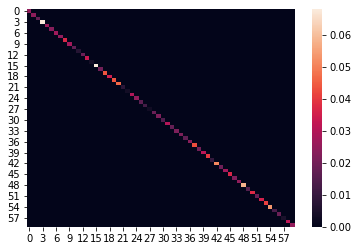

In [95]:
import seaborn as sns
sns.heatmap((model.task_covar_module.covar_matrix.evaluate()).detach().numpy())